## Overview: <a class="anchor" id="top"></a>
* [Interactive ChIP-seq analysis](#01)
    * [Our dataset](#01.1)
    * [Set up](#01.2)
    * [Tag profile plot](#01.3)
    * [Annotate peaks](#01.4)
    * [Functional enrichment analysis](#01.5)
    * [Overlap of peaks](#01.6)
* [Linking RNA-seq results with ChIP-seq results](#02)
    * [Viewing integrated data in IGV](#02.1)
    * [More advanced integration](#02.2)
* [Other useful tools](#03)

# Interactive ChIP-seq analysis<a class="anchor" id="01"></a> <small>[[top](#top)]</small>

We will go through some basic annotation of your peaks and some visualization using the 
[ChIPSeeker](http://bioconductor.org/packages/release/bioc/html/ChIPseeker.html) 
BioconductoR package.

> G Yu, LG Wang, QY He.
ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization.
Bioinformatics 2015, 31(14):2382-2383.

## Our dataset<a class="anchor" id="01.1"></a> <small>[[top](#top)]</small>

* Same publication as the RNA-Seq set ([link](https://www.ncbi.nlm.nih.gov/pubmed/25499759))
* Two factors:
    * Ab1 factor for PRDM11 gene
    * RNAII factor for RNA polymerase
* Two controls:
    * Input sample
    * IgG sample
* We will use pre-analyzed data due to time limitations
* More examples are available in the extended notebooks

## Set up<a class="anchor" id="01.2"></a> <small>[[top](#top)]</small>

First, we will load the necessary R libraries and peak files in R.

In [10]:
# Load the libraries
# These will need to be installed already
suppressMessages(require(ChIPseeker))
suppressMessages(require(TxDb.Hsapiens.UCSC.hg38.knownGene))
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

# Set up the input files. I hardcoded the directory path
# that contains all the narrowPeak files. We then create
# a list where each item is the treatment group and the path
# to the narrowPeak file
#idir <- "/home/ubuntu/data/chipseq/fullset/peaks"
idir <- "/home/kmhernan/Projects/CRI/Internal/Workshop-2016/data/fullset/peaks"
files <- list("Ab1"=file.path(idir, "Ab1.filtered.intersected.narrowPeak"),
              "RNAPII"=file.path(idir, "RNAPII.filtered.intersected.narrowPeak"))

# Look at the files list
print("Files list:")
files

# Now, we use the readPeakFile() function that is provided by
# the ChIPseeker package. We use the lapply function so that we
# can easily loop over the files list and load in the peaks.
peaks <- lapply(files, function(x) readPeakFile(x, header=FALSE))

# There should be 2 elements in the list that are identified by the
# treatment name.
print("Peak list names:")
names(peaks)

# We can peek at one of the treatment's peak data
print("Peak data from Ab1:")
peaks$Ab1

[1] "Files list:"


$Ab1
[1] "/home/kmhernan/Projects/CRI/Internal/Workshop-2016/data/fullset/peaks/Ab1.filtered.intersected.narrowPeak"

$RNAPII
[1] "/home/kmhernan/Projects/CRI/Internal/Workshop-2016/data/fullset/peaks/RNAPII.filtered.intersected.narrowPeak"

[1] "Peak list names:"


[1] "Ab1"    "RNAPII"

[1] "Peak data from Ab1:"


GRanges object with 7346 ranges and 7 metadata columns:
         seqnames                 ranges strand |                   V4
            <Rle>              <IRanges>  <Rle> |             <factor>
     [1]    chr10     [ 134356,  134899]      * |  Ab1.input_peak_2206
     [2]    chr10     [1489238, 1489661]      * |  Ab1.input_peak_2215
     [3]    chr10     [2987846, 2988081]      * |  Ab1.input_peak_2226
     [4]    chr10     [3172410, 3172896]      * |  Ab1.input_peak_2231
     [5]    chr10     [3810133, 3810393]      * |  Ab1.input_peak_2236
     ...      ...                    ...    ... .                  ...
  [7342]     chrX [154762498, 154762833]      * | Ab1.input_peak_29547
  [7343]     chrX [154805120, 154805605]      * | Ab1.input_peak_29548
  [7344]     chrX [155026792, 155027037]      * | Ab1.input_peak_29549
  [7345]     chrX [155263928, 155264220]      * | Ab1.input_peak_29550
  [7346]     chrX [155264331, 155264568]      * | Ab1.input_peak_29551
                V5   

## Tag profile plot<a class="anchor" id="01.3"></a> <small>[[top](#top)]</small> 

* Visualize profile of ChIP peaks binding to Transcription Start Site (TSS) regions
* To do this, a `tagMatrix` needs to be computed. This can take several minutes, so we will load a previously generated one due to time contraints
* Use the `plotAvgProf` function to do the plot
* It is possible to do bootstrapping to get confidence intervals (not shown)

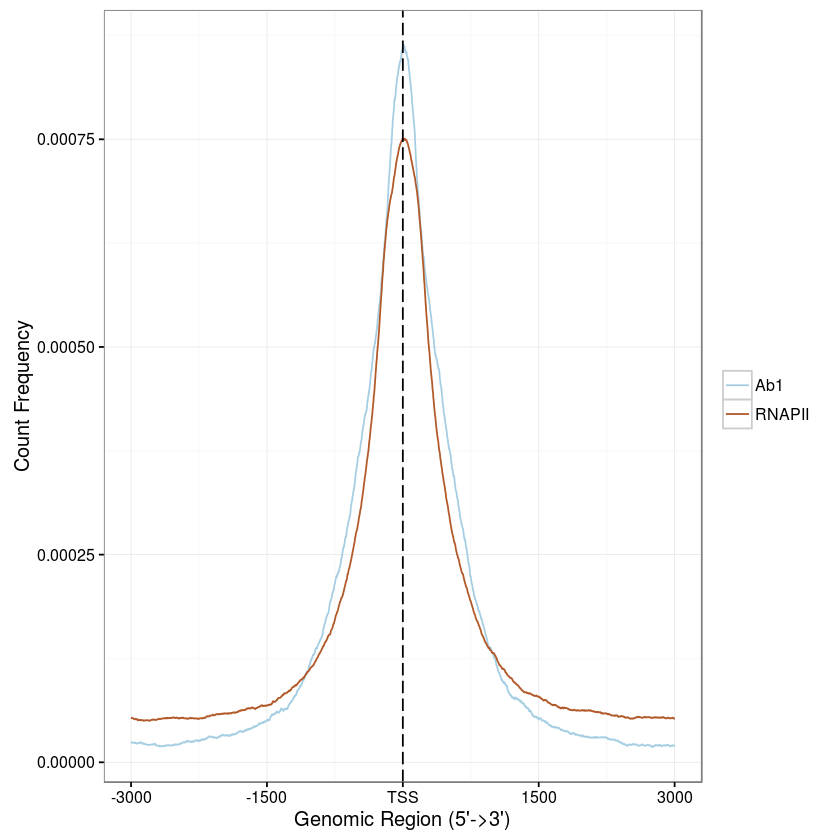

In [12]:
## We first need to create a tagMatrix which requires us to provide the
## locations of the promoters. Fortunately, we can use the getPromoters function
## with the TxDb object
#
# promoter <- getPromoters(TxDb=txdb, upstream=3000, downstream=3000)
#
## Next, we can make the tagMatrix using the lapply function and our peak list
# tagMatrix <- lapply(peaks, function(x) getTagMatrix(x, windows=promoter))

# Since we already pre-computed the tag matrix, we will load it here
load(file.path(idir, "Rdata", "tagMatrix.Rdata"))

# Plot the average profile
plotAvgProf(tagMatrix, xlim=c(-3000, 3000), 
            xlab="Genomic Region (5'->3')", 
            ylab="Count Frequency")

## Annotate peaks<a class="anchor" id="01.4"></a> <small>[[top](#top)]</small>

* Lookup the gene with the closest TSS to our peaks
* Get genomic feature where our peak is located (e.g., promoter, 5'UTR, etc.)
* Use the `annotatePeak` function and annotation datasets provided by R/Bioconductor
* This function takes some time, so we will load previously generated data

In [6]:
## We will apply the annotatePeak function to every peak set in our
## peak list using the lapply method
#
# peakAnnoList <- lapply(peaks, annotatePeak, TxDb=txdb, 
#                       tssRegion=c(-3000, 3000),
#                       annoDb="org.Hs.eg.db", verbose=FALSE)

# Since we are not computing this here, we will load the pre-computed dataset
load(file.path(idir, "Rdata", "peakAnnoList.Rdata"))

# If we peek at the Ab1 data, we will get a nice summary.
print("Summary of Ab1 annotation:")
peakAnnoList$Ab1

[1] "Summary of Ab1 annotation:"


Annotated peaks generated by ChIPseeker
7346/7346  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (1-2kb)  3.8115981
10   Promoter (<=1kb) 79.1451130
11   Promoter (2-3kb)  1.3204465
4              5' UTR  0.3130956
3              3' UTR  0.8031582
1            1st Exon  0.4356112
7          Other Exon  1.5654778
2          1st Intron  1.4429622
8        Other Intron  2.9131500
6  Downstream (<=3kb)  0.4219984
5   Distal Intergenic  7.8273891

### Visualize genomic feature distribution of peaks

* Shows the percentage of peaks in various regions (e.g., promoter, intron, downstream, etc.)
* Show differences between treatments/factors
* In most transcription factor cases, we expect a lot of peaks closer to the promoter; however, this depends on the biology of your protein of interest
* Use the `plotAnnoBar` function

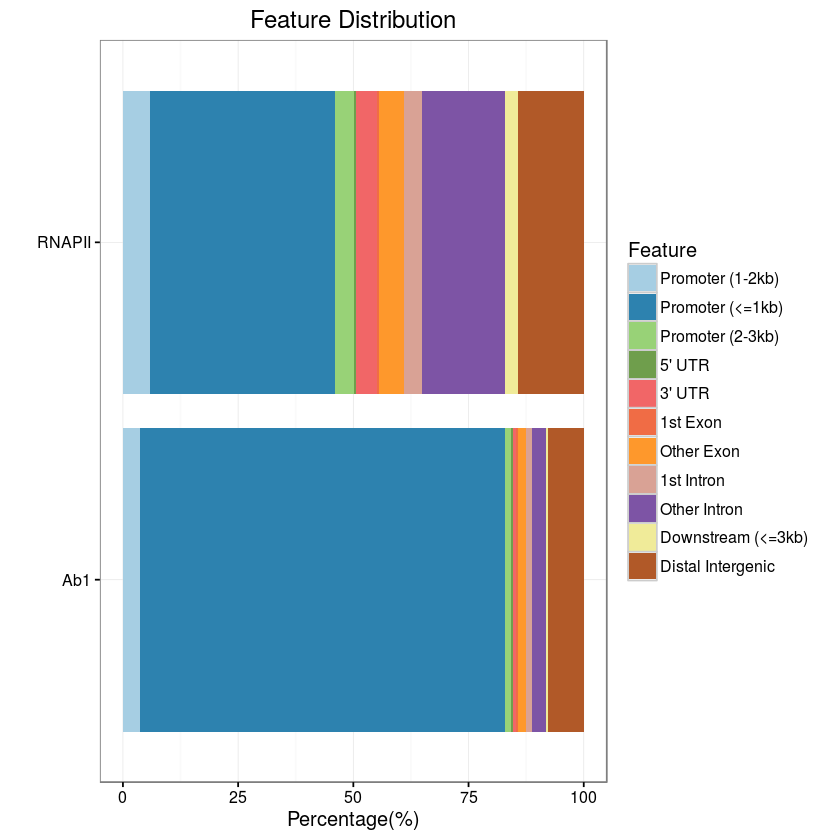

In [7]:
# The barchart allows you to plot multiple samples, so
# you can pass the peakAnnoList
plotAnnoBar(peakAnnoList)

## Functional enrichment analysis<a class="anchor" id="01.5"></a> <small>[[top](#top)]</small>

* What are our potential binding target genes enriched in?
* We will need ENTREZ gene IDs to perform functional enrichment
* ChIPseeker provides a convenient function `seq2gene` to to handle many-to-many mappings in your peak annotations and is recommended for doing enrichment analyses

In [11]:
# Load the clusterProfiler package
suppressMessages(require(clusterProfiler))

# Use the seq2gene function to make gene lists for functional analysis
# Notice that we are passing the original, unannotated peak data
genes.ab1 <- seq2gene(peaks$Ab1, tssRegion = c(-3000, 3000), flankDistance=3000, TxDb=txdb)
genes.rnapii <- seq2gene(peaks$RNAPII, tssRegion = c(-3000, 3000), flankDistance=3000, TxDb=txdb)

# Next, we will create a list containing these gene lists
geneList <- list("Ab1"=genes.ab1, "RNAPII"=genes.rnapii)

# Print first few genes
print("First few Ab1 genes:")
head(geneList$Ab1)

print("First few RNAPII genes:")
head(geneList$RNAPII)

[1] "First few Ab1 genes:"


[1] "10771" "10531" "54906" "3601"  "84991" "5209"

[1] "First few RNAPII genes:"


[1] "10771" "23185" "23560" "91734" "55853" "3422"

* Using the `geneList` we just created, we can perform enrichment
* Use the same enrichment package mentioned before, [clusterProfiler](http://bioconductor.org/packages/release/bioc/html/clusterProfiler.html)
* We will run KEGG pathway enrichment
* Since this takes some time to run, we will load previously generated data

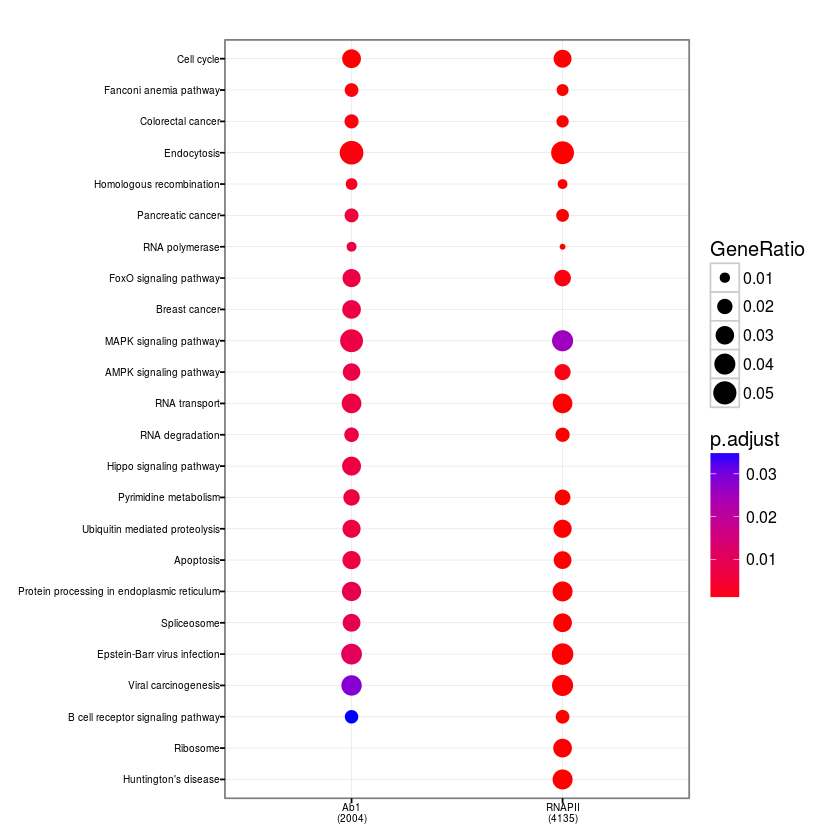

In [11]:
## KEGG Pathway enrichment
## We use the compareCluster function with the enrichKEGG method
#
# kegg.res <- compareCluster(geneList, fun = "enrichKEGG", organism='hsa')

# Since we have pre-computed results we need to load them
load(file.path(idir, "Rdata", "kegg.res.Rdata"))

# Now, we plot the top 15 kegg pathways from each peak set
dotplot(kegg.res, showCategory=15, font.size=6)

## Overlap of peaks<a class="anchor" id="01.6"></a> <small>[[top](#top)]</small>

* Common analysis in ChIP-Seq
* Compare overlap of peaks across treatments/factors
* Use the `vennplot` function on our input peaks (`peaks`)

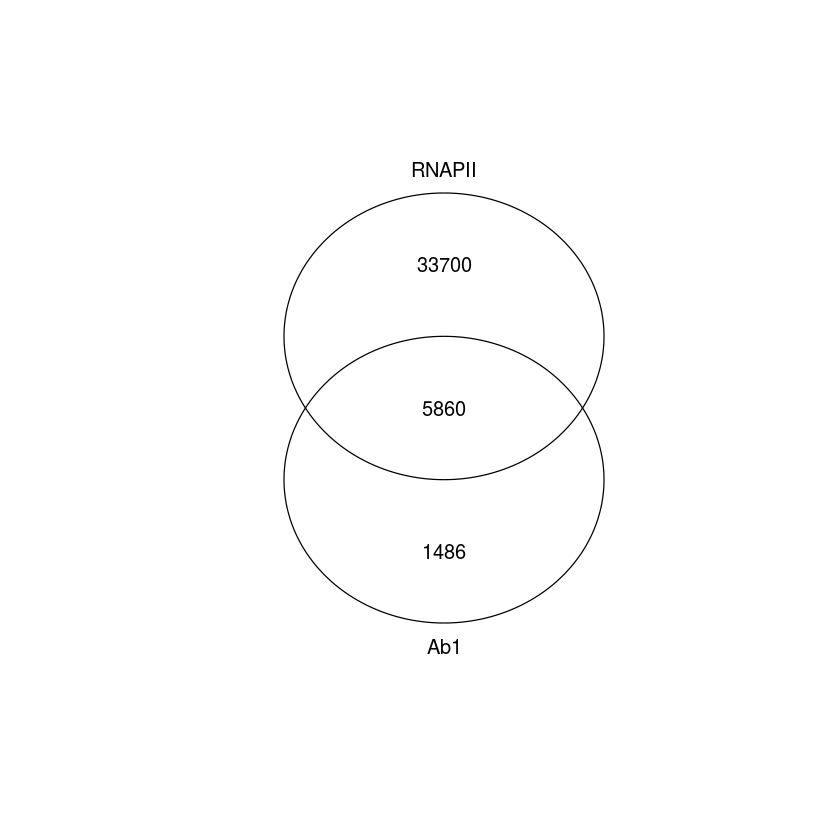

In [13]:
# Venn diagram of peak overlaps
vennplot(peaks)

# Linking RNA-seq results with ChIP-seq results<a class="anchor" id="02"></a> <small>[[top](#top)]</small>

* Integrate the binding target of ChIP-seq with differentially expressed genes
* I intersected the Ab1 and RNAPII peaks to get the overlapping ones for this analysis
* We will first load these intersected peaks in to R using ChIPseeker

In [2]:
# Load the libraries
# These will need to be installed already
suppressMessages(require(ChIPseeker))
suppressMessages(require(TxDb.Hsapiens.UCSC.hg38.knownGene))
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

# Load in the overlapping peaks
#idir <- "/home/ubuntu/data/chipseq/fullset"
idir <- "/home/kmhernan/Projects/CRI/Internal/Workshop-2016/data/fullset"
chip.peaks <- readPeakFile(file.path(idir, "peaks", "Ab1_RNAPII.overlapped.filtered.intersected.narrowPeak"), 
                           header=FALSE)

# Peek at the data
head(chip.peaks)

GRanges object with 6 ranges and 7 metadata columns:
      seqnames             ranges strand |                  V4        V5
         <Rle>          <IRanges>  <Rle> |            <factor> <integer>
  [1]    chr10 [1489238, 1489661]      * | Ab1.input_peak_2215        51
  [2]    chr10 [3172410, 3172896]      * | Ab1.input_peak_2231       109
  [3]    chr10 [5665920, 5666392]      * | Ab1.input_peak_2242       324
  [4]    chr10 [5684424, 5684866]      * | Ab1.input_peak_2243       593
  [5]    chr10 [5775761, 5776080]      * | Ab1.input_peak_2245       125
  [6]    chr10 [5977538, 5978102]      * | Ab1.input_peak_2251        92
            V6        V7        V8        V9       V10
      <factor> <numeric> <numeric> <numeric> <integer>
  [1]        .   4.06589   7.85770   5.11926       275
  [2]        .   5.36279  14.11020  10.98270       354
  [3]        .  12.79724  36.38798  32.48447       313
  [4]        .  19.03980  63.71320  59.39371       222
  [5]        .   5.73264  15.7948

* Next, we will annotate using the `annotatePeak` function. Due to time constraints, we will load the previously generated data

In [3]:
## Annotate
# peakAnno <- annotatePeak(chip.peaks, TxDb=txdb, 
#                          tssRegion=c(-3000,3000),
#                          annoDb="org.Hs.eg.db", verbose=FALSE)

# We will simply load the pre-existing Robject
load(file.path(idir, "peaks", "Rdata", "Ab1_RNAPII.overlapped.annotated.Rdata"))

# Show the names of the annotated columns 
names(as.data.frame(peakAnno))

[1] "seqnames"      "start"         "end"           "width"        
 [5] "strand"        "V4"            "V5"            "V6"           
 [9] "V7"            "V8"            "V9"            "V10"          
[13] "annotation"    "geneChr"       "geneStart"     "geneEnd"      
[17] "geneLength"    "geneStrand"    "geneId"        "transcriptId" 
[21] "distanceToTSS" "ENSEMBL"       "SYMBOL"        "GENENAME"

* Subset peaks within a particular distance from the TSS using the `distanceToTSS` column
* We will use an arbitrary distance of 30,000bp (depends on your protein of interest and biological question)
* Subset the annotated data using the `subset` function

In [4]:
## Subset peaks by the absolute value of distanceToTSS
## We arbitrarily chose 30,000 bp as the cutoff. We also
## need to remove peaks where there is no known official gene symbol.
## We can do this using the is.na() function
peakAnno.30kb <- subset(as.data.frame(peakAnno), abs(distanceToTSS) < 30000 & !is.na(SYMBOL))

## Next, let's create a vector of unique gene symbols
genes.chip <- unique(peakAnno.30kb$SYMBOL)
print("The number of unique genes:")
length(genes.chip)

[1] "The number of unique genes:"


[1] 4565

* At this point we have the ChIP-seq data we need, so we will now load in the RNA-seq data

In [6]:
## Load in the RNA-seq data you output earlier
rnaseq.dat <- read.delim(file.path(idir, "rnaseq", "DLBC.coding.KOvsWT.deseq2.txt.flt.fdr0.05_fc1.5"),
                        header=TRUE, stringsAsFactors=FALSE)

## Peek at data
head(rnaseq.dat)

ENSEMBL,SYMBOL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,foldChange
ENSG00000006282.20,SPATA20,339.18678,-0.6136447,0.11428784,-5.369291,7.904659e-08,4.426258e-06,-1.530120
ENSG00000007944.14,MYLIP,498.97981,-0.8256700,0.10832360,-7.622254,2.492846e-14,6.409666e-12,-1.772358
ENSG00000019549.8,SNAI2,143.41913,0.6023509,0.15267109,3.945416,7.966161e-05,1.475966e-03,1.518188
ENSG00000026025.13,VIM,101.16900,-0.7806354,0.16508484,-4.728692,2.259707e-06,7.864655e-05,-1.717887
ENSG00000035403.16,VCL,853.07441,-1.0732866,0.09343159,-11.487407,1.526253e-30,2.403657e-27,-2.104222
ENSG00000036828.13,CASR,43.93388,0.6640367,0.18040775,3.680755,2.325442e-04,3.551303e-03,1.584510


* Subset our RNA-Seq data to the genes found in the ChIP-Seq dataset using the `subset()` command

In [7]:
## Select rows from RNA-Seq data that contain genes in the
## ChIP-Seq dataset
shared.dat <- subset(rnaseq.dat, SYMBOL %in% genes.chip)

print("There are this many overlapping genes:")
dim(shared.dat)[1]

print("These are the overlapping genes:")
shared.dat$SYMBOL

[1] "There are this many overlapping genes:"


[1] 58

[1] "These are the overlapping genes:"


[1] "MYLIP"     "SNAI2"     "SREBF1"    "LRRC16A"   "DDX43"     "STRADB"   
 [7] "FAM234B"   "CYP26A1"   "CTSH"      "LIPA"      "ALDOC"     "LPCAT3"   
[13] "PFKFB4"    "HES1"      "CD274"     "ACAT2"     "HIST1H2BJ" "RUNX2"    
[19] "FAM78A"    "VAV3"      "RAB33A"    "FADS2"     "TNS3"      "IGF2BP3"  
[25] "CCNG2"     "LEF1"      "AK7"       "ZNF687"    "TMEM123"   "CABP1"    
[31] "HIST1H4H"  "RUNX1"     "SPON2"     "SLC2A6"    "RPRD2"     "RBM47"    
[37] "KIAA0895"  "SNAPC3"    "STK32C"    "GYLTL1B"   "TUBA1A"    "SHOX2"    
[43] "FOS"       "ZNF804A"   "ESRRA"     "ORAI3"     "EGR3"      "SERTAD2"  
[49] "POLR2A"    "WRB"       "NANOS1"    "HIST1H3J"  "HIST2H2BF" "CTSO"     
[55] "HIST1H3B"  "HIST1H4E"  "HIST1H2BF" "HIST1H3H"

* We now of the expression data from differentially expressed genes that also had peaks within 30kb from the TSS site!
* Let's run KEGG enrichment

Loading required package: org.Hs.eg.db

'select()' returned 1:1 mapping between keys and columns


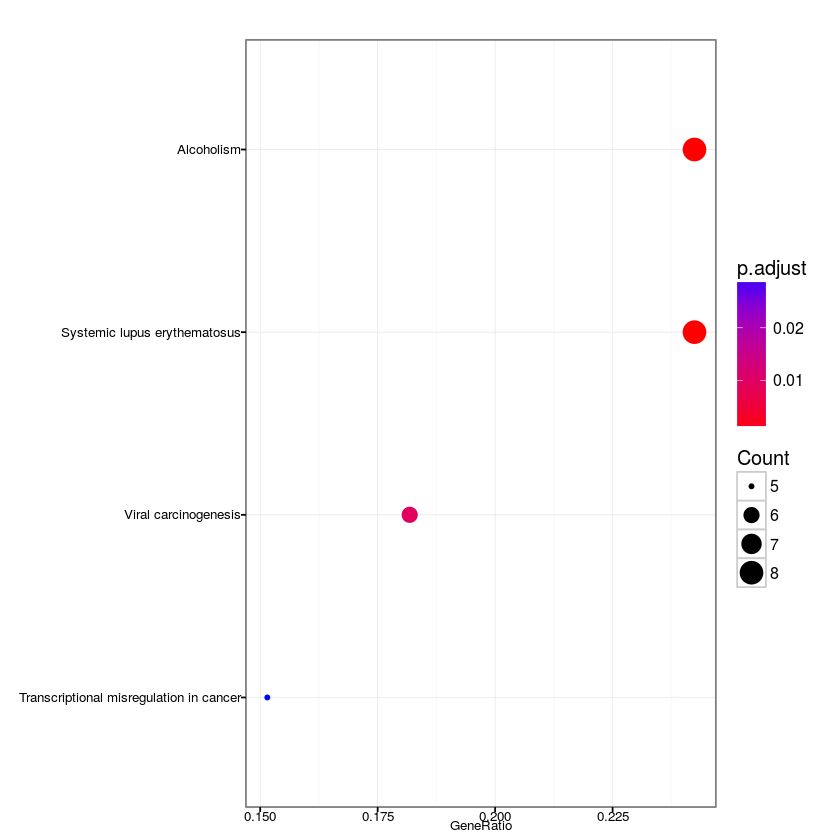

In [8]:
## An example of running KEGG pathway enrichment on the ovelapping genes
suppressMessages(library(clusterProfiler))

## Use the built-in bitr function to get the ENTREZIDs from the symbols
entrez.shared <- bitr(shared.dat$SYMBOL, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")

## Run KEGG enrichment
kegg.res <- enrichKEGG(gene=entrez.shared$ENTREZID,
                  org = 'hsa',
                  pAdjustMethod="BH",
                  qvalueCutoff=0.05)
dotplot(kegg.res, font.size=8)

## Viewing integrated data in IGV<a class="anchor" id="02.1"></a> <small>[[top](#top)]</small>

* Screenshot of the [FOS](http://www.genecards.org/cgi-bin/carddisp.pl?gene=FOS) gene
* bigWig files from ChIP-Seq and RNA-Seq
* [Integrative Genomics Viewer](http://software.broadinstitute.org/software/igv/)

<img src="workshop_extended/assets/f09_FOS_integration_anno_IGV.png" alt="Figure 09" style="float: center;"/>

## More advanced integration<a class="anchor" id="02.2"></a> <small>[[top](#top)]</small>

If you would like to perform a more advanced integration, I suggest you look into the [BETA](http://cistrome.org/BETA/) software from Cistrome.

> Wang, S., Sun, H., Ma, J., Zang, C., Wang, C., Wang, J., ... & Liu, X. S. (2013). Target analysis by integration of transcriptome and ChIP-seq data with BETA. Nature protocols, 8(12), 2502-2515. 

They provide both stand-alone and Galaxy-based access to BETA. Here is a brief description of BETA:

> Binding and Expression Target Analysis (BETA) is a software package that integrates ChIP-seq of transcription factors or chromatin regulators with differential gene expression data to infer direct target genes. BETA has three functions: (1) to predict whether the factor has activating or repressive function; (2) to infer the factor’s target genes; and (3) to identify the motif of the factor and its collaborators which might modulate the factor’s activating or repressive function. Here we describe the implementation and features of BETA to demonstrate its application to several datasets. BETA requires ~2GB RAM and 1h for the whole procedure.

# Other useful tools<a class="anchor" id="03"></a> <small>[[top](#top)]</small>

* If you have replicates and multiple conditions for your ChIP-Seq data, the R/Bioconductor package [DiffBind](https://bioconductor.org/packages/release/bioc/html/DiffBind.html) provides several statistical methods for examining differential binding
* [Homer](http://homer.salk.edu/homer/) is a popular suite of ChIP-Seq tools
* The [Regulatory Genomics Toolbox](http://www.regulatory-genomics.org/) provides several python tools for ChIP-Seq analyses
* [OmicTools](https://omictools.com/chip-seq-category) has a nice aggregation of various ChIP-Seq tools and databases